In [11]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm # linear regression
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scanpy as sc
import os

#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' 
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
#*****
# Seed number
np.random.seed(2025)
random.seed(2025)

In [12]:
adata_rna_A1 = sc.read("adata_A1_rna_raw_data.h5ad")
adata_rna_B1 = sc.read("adata_B1_rna_raw_data.h5ad")
adata_rna_D1 = sc.read("adata_D1_rna_raw_data.h5ad")

adata_protein_A1 = sc.read("adata_A1_protein_raw_data.h5ad")
adata_protein_B1 = sc.read("adata_B1_protein_raw_data.h5ad")
adata_protein_D1 = sc.read("adata_D1_protein_raw_data.h5ad")

adata_protein_pair_A1 = sc.read("adata_A1_protein_pair_raw_data.h5ad")
adata_protein_pair_B1 = sc.read("adata_B1_protein_pair_raw_data.h5ad")
adata_protein_pair_D1 = sc.read("adata_D1_protein_pair_raw_data.h5ad")

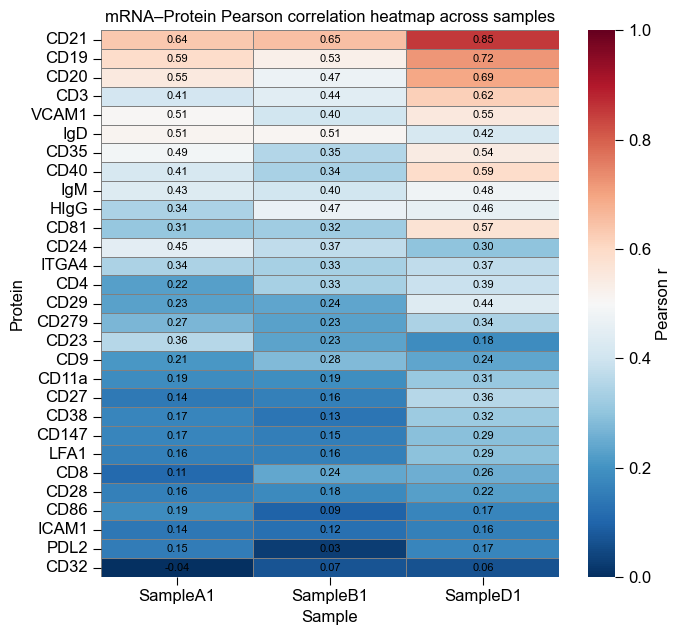

In [16]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os

# === Step 1: Define correlation function ===
def calculate_correlation_log2(gene, protein, adata_rna, adata_protein, method='pearson'):
    common_cells = adata_rna.obs_names.intersection(adata_protein.obs_names)
    adata_rna = adata_rna[common_cells]
    adata_protein = adata_protein[common_cells]

    # Use raw counts
    gene_data = adata_rna[:, gene].layers["counts"]
    protein_data = adata_protein[:, protein].layers["counts"]

    gene_expression = gene_data.toarray().flatten() if scipy.sparse.issparse(gene_data) else gene_data.flatten()
    protein_expression = protein_data.toarray().flatten() if scipy.sparse.issparse(protein_data) else protein_data.flatten()

    # Filter out 0 values
    mask = (gene_expression > 0) & (protein_expression > 0)
    if np.sum(mask) < 3:
        return np.nan

    x = np.log2(gene_expression[mask])
    y = np.log2(protein_expression[mask])

    if method == 'pearson':
        return stats.pearsonr(x, y)[0]
    elif method == 'spearman':
        return stats.spearmanr(x, y)[0]
    else:
        raise ValueError("method must be 'pearson' or 'spearman'")


# === Step 2: Define protein-gene map ===
protein_to_gene = {
    'CD19': 'CD19', 'CD20': 'MS4A1', 'CD21': 'CR2', 'CD35': 'CR1', 'CD3': 'CD3D', 'CD4': 'CD4',
    'CD8': 'CD8A', 'IgD': 'IGHD', 'IgM': 'IGHM', 'HIgG': 'IGHG1', 'CD147': 'BSG', 'CD23': 'FCER2',
    'CD24': 'CD24', 'CD27': 'CD27', 'CD279': 'PDCD1', 'CD28': 'CD28', 'CD40': 'CD40',
    'PDL2': 'PDCD1LG2', 'CD86': 'CD86', 'CD32': 'FCGR2A', 'CD38': 'CD38', 'CD81': 'CD81',
    'CD9': 'CD9', 'VCAM1': 'VCAM1', 'ICAM1': 'ICAM1', 'ITGA4': 'ITGA4', 'LFA1': 'ITGAL',
    'CD29': 'ITGB1', 'CD11a': 'ITGAL'
}


# === Step 3: Get common valid proteins ===
valid_proteins = [p for p in protein_to_gene if p in adata_protein_A1.var_names and protein_to_gene[p] in adata_rna_A1.var_names]

# === Step 4: Correlation calculation wrapper ===
def compute_correlation_for_sample(adata_rna, adata_protein, sample_name):
    result = {}
    for protein in valid_proteins:
        gene = protein_to_gene[protein]
        try:
            r = calculate_correlation_log2(gene, protein, adata_rna, adata_protein)
            result[protein] = r
        except Exception as e:
            print(f"[WARN] {sample_name}: {protein}-{gene} failed ({e})")
            result[protein] = np.nan
    return pd.DataFrame.from_dict(result, orient='index', columns=[sample_name])


# === Step 5: Compute correlations ===
df_A1 = compute_correlation_for_sample(adata_rna_A1, adata_protein_A1, "SampleA1")
df_B1 = compute_correlation_for_sample(adata_rna_B1, adata_protein_B1, "SampleB1")
df_D1 = compute_correlation_for_sample(adata_rna_D1, adata_protein_D1, "SampleD1")

# === Step 6: Combine and Save ===
df_combined = pd.concat([df_A1, df_B1, df_D1], axis=1)
df_combined.to_csv("combined_pearson_r_log2.csv")

# === Step 7: Plot heatmap ===
df_sorted = df_combined.copy()
df_sorted["mean"] = df_sorted.mean(axis=1)
df_sorted = df_sorted.sort_values(by="mean", ascending=False).drop(columns=["mean"])

# Ensure save directory exists
os.makedirs("figures", exist_ok=True)

fig, ax = plt.subplots(figsize=(7, len(df_sorted) * 0.19 + 1))
sns.heatmap(df_sorted.astype(float),
            cmap='RdBu_r', vmin=0, vmax=1,
            linewidths=0.5, linecolor='grey',
            cbar_kws={'label': 'Pearson r'},
            ax=ax)

# Annotate values
for y in range(df_sorted.shape[0]):
    for x in range(df_sorted.shape[1]):
        val = df_sorted.iloc[y, x]
        if not np.isnan(val):
            ax.text(x + 0.5, y + 0.5, f"{val:.2f}", ha='center', va='center', color='black', fontsize=8)

ax.set_title("mRNA–Protein Pearson correlation heatmap across samples")
ax.set_xlabel("Sample")
ax.set_ylabel("Protein")
plt.tight_layout()
plt.savefig("figures/Extended-Fig-8a.svg", dpi=300)
plt.show()


In [17]:
# RNA log1p expression (genes × spots) from .raw
rna_A1 = pd.DataFrame(adata_rna_A1.raw.X.toarray(), columns=adata_rna_A1.raw.var_names, index=adata_rna_A1.obs_names)
rna_B1 = pd.DataFrame(adata_rna_B1.raw.X.toarray(), columns=adata_rna_B1.raw.var_names, index=adata_rna_B1.obs_names)
rna_D1 = pd.DataFrame(adata_rna_D1.raw.X.toarray(), columns=adata_rna_D1.raw.var_names, index=adata_rna_D1.obs_names)

# Protein log1p expression
protein_A1 = pd.DataFrame(adata_protein_A1.raw.X, columns=adata_protein_A1.var_names, index=adata_protein_A1.obs_names)
protein_B1 = pd.DataFrame(adata_protein_B1.raw.X, columns=adata_protein_B1.var_names, index=adata_protein_B1.obs_names)
protein_D1 = pd.DataFrame(adata_protein_D1.raw.X, columns=adata_protein_D1.var_names, index=adata_protein_D1.obs_names)

# Protein pair log1p expression
protein_pair_A1 = pd.DataFrame(adata_protein_pair_A1.raw.X, columns=adata_protein_pair_A1.var_names, index=adata_protein_pair_A1.obs_names)
protein_pair_B1 = pd.DataFrame(adata_protein_pair_B1.raw.X, columns=adata_protein_pair_B1.var_names, index=adata_protein_pair_B1.obs_names)
protein_pair_D1 = pd.DataFrame(adata_protein_pair_D1.raw.X, columns=adata_protein_pair_D1.var_names, index=adata_protein_pair_D1.obs_names)


In [18]:
def compute_filtered_correlation(df, markers, method='pearson', min_valid=3):
    """
    Compute correlation matrix using already log-normalized data,
    using only spots where both markers are > 0 (non-zero log expression).

    Parameters:
        df (DataFrame): log-normalized data (spots × markers)
        markers (list): markers to include
        method (str): 'pearson' or 'spearman'
        min_valid (int): minimum number of shared non-zero spots to compute correlation

    Returns:
        DataFrame: correlation matrix (markers × markers)
    """
    present = [m for m in markers if m in df.columns]
    corr_matrix = pd.DataFrame(np.nan, index=present, columns=present)

    for i, m1 in enumerate(present):
        for j, m2 in enumerate(present):
            if j < i:
                continue
            x = df[m1].values
            y = df[m2].values
            mask = (x > 0) & (y > 0)
            if np.sum(mask) < min_valid:
                continue
            if method == 'pearson':
                corr = stats.pearsonr(x[mask], y[mask])[0]
            else:
                corr = stats.spearmanr(x[mask], y[mask])[0]
            corr_matrix.loc[m1, m2] = corr
            corr_matrix.loc[m2, m1] = corr
    return corr_matrix


In [19]:
# Your protein to gene mapping
protein_to_gene = {
     'CD19': 'CD19', 'CD20': 'MS4A1', 'CD21': 'CR2', 'CD35': 'CR1', 'CD3': 'CD3D', 'CD4': 'CD4',
    'CD8': 'CD8A', 'IgD': 'IGHD', 'IgM': 'IGHM', 'HIgG': 'IGHG1',
    'CD147': 'BSG', 'CD23': 'FCER2', 'CD24': 'CD24', 'CD27': 'CD27',
    'CD279': 'PDCD1', 'CD28': 'CD28', 'CD40': 'CD40', 'PDL2': 'PDCD1LG2', 'CD86': 'CD86',
    'CD32': 'FCGR2A', 'CD38': 'CD38',
    'CD81': 'CD81', 'CD9': 'CD9', 'VCAM1': 'VCAM1', 'ICAM1': 'ICAM1', 'ITGA4': 'ITGA4',
  'CD29': 'ITGB1', 'CD11a': 'ITGAL','LFA1': 'ITGAL',
}

In [20]:
# Use the keys from protein_to_gene as the list of protein markers
protein_markers = list(protein_to_gene.keys())
rna_markers = list(set(protein_to_gene.values()))  # Remove duplicates using set, then convert back to list


In [21]:
# Protein correlation
corr_protein_A1 = compute_filtered_correlation(protein_A1, protein_markers)
corr_protein_B1 = compute_filtered_correlation(protein_B1, protein_markers)
corr_protein_D1 = compute_filtered_correlation(protein_D1, protein_markers)

# RNA correlation
corr_rna_A1 = compute_filtered_correlation(rna_A1, rna_markers)
corr_rna_B1 = compute_filtered_correlation(rna_B1, rna_markers)
corr_rna_D1 = compute_filtered_correlation(rna_D1, rna_markers)

# Average expression (raw), then correlation
protein_avg = (protein_A1[protein_markers] + protein_B1[protein_markers] + protein_D1[protein_markers]) / 3
rna_avg = (rna_A1[rna_markers] + rna_B1[rna_markers] + rna_D1[rna_markers]) / 3

corr_protein_mean = compute_filtered_correlation(protein_avg, protein_markers)
corr_rna_mean = compute_filtered_correlation(rna_avg, rna_markers)

# Collect results
corr_dict_protein = {
    "Protein–Protein Correlation (Mean)": corr_protein_mean,
    "Protein–Protein Correlation (A1)": corr_protein_A1,
    "Protein–Protein Correlation (B1)": corr_protein_B1,
    "Protein–Protein Correlation (D1)": corr_protein_D1,
}

corr_dict_rna = {
    "RNA–RNA Correlation (Mean)": corr_rna_mean,
    "RNA–RNA Correlation (A1)": corr_rna_A1,
    "RNA–RNA Correlation (B1)": corr_rna_B1,
    "RNA–RNA Correlation (D1)": corr_rna_D1,
}


In [22]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

def plot_fixed_order_correlation_heatmaps(
    corr_dict_protein,
    corr_dict_rna,
    protein_to_gene,
    figsize=(6, 6),
    font_size=10,
    label_rotation=90,
    save=True,
    output_dir="figures"
):
    """
    Plot all correlation heatmaps using fixed order from mean protein clustering, and save them to ./figures/.

    Parameters:
        corr_dict_protein: dict of title -> protein correlation DataFrame
        corr_dict_rna: dict of title -> RNA correlation DataFrame
        protein_to_gene: dict of protein -> gene mapping
        figsize: heatmap size
        font_size: tick font size
        label_rotation: x-axis rotation
        save: whether to save each plot as PNG (default: True)
        output_dir: folder to save heatmaps (default: 'figures')
    """
    if save:
        os.makedirs(output_dir, exist_ok=True)

    # === 1. Restrict to mapped proteins in the same order ===
    valid_proteins = list(protein_to_gene.keys())
    mean_protein_corr = corr_dict_protein["Protein–Protein Correlation (Mean)"]
    sub_corr = mean_protein_corr.loc[valid_proteins, valid_proteins]

    # Cluster rows/columns of the protein-protein matrix
    cg = sns.clustermap(sub_corr, cmap="RdBu_r", center=0.5)
    plt.close()

    ordered_proteins = sub_corr.index[cg.dendrogram_row.reordered_ind].tolist()

    # === 2. Match corresponding genes in the same order, avoiding duplicates ===
    mean_rna_corr = corr_dict_rna["RNA–RNA Correlation (Mean)"]
    seen = set()
    ordered_genes = []
    for p in ordered_proteins:
        g = protein_to_gene[p]
        if g in mean_rna_corr.columns and g not in seen:
            ordered_genes.append(g)
            seen.add(g)

    # === 3. Plot one matrix ===
    def plot_single(title, corr, labels, prefix):
        corr_fixed = corr.loc[labels, labels]
        plt.figure()
        g = sns.heatmap(
            corr_fixed,
            cmap="RdBu_r",
            square=True,
            linewidths=0.5,
            vmin=-1,
            vmax=1.2,
            xticklabels=True,
            yticklabels=True,
            cbar_kws={
                "label": "Correlation",
                "shrink": 0.3,
                "aspect": 20
            },
        )
        g.set_xticklabels(g.get_xticklabels(), rotation=label_rotation, fontsize=font_size)
        g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=font_size)
        plt.title(title, fontsize=10)
        plt.gcf().set_size_inches(figsize)
        plt.tight_layout()
        if save:
            filename = os.path.join(output_dir, f"{prefix}_{title.replace(' ', '_')}.svg")
            plt.savefig(filename, dpi=300)
        plt.show()

    # === 4. Plot all ===
    for title, corr in corr_dict_protein.items():
        plot_single(title, corr, ordered_proteins, prefix="protein")

    for title, corr in corr_dict_rna.items():
        plot_single(title, corr, ordered_genes, prefix="rna")


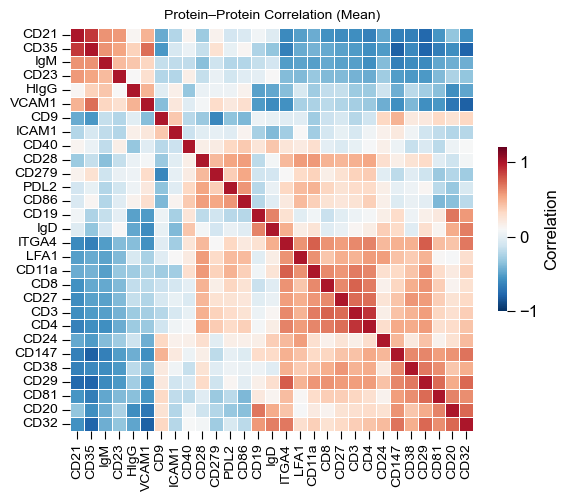

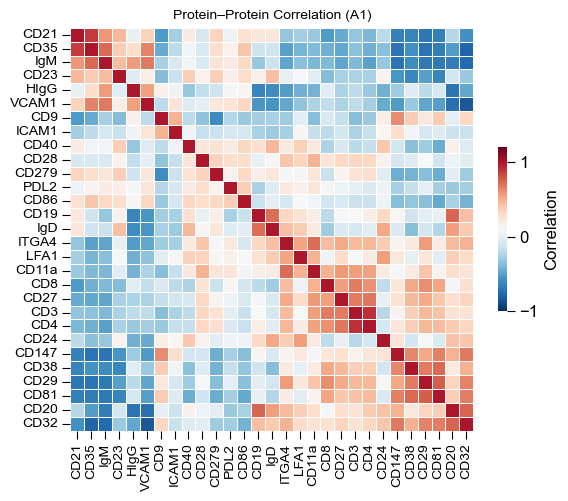

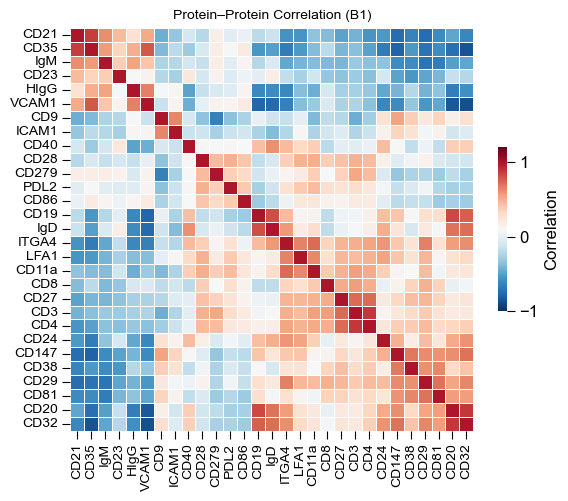

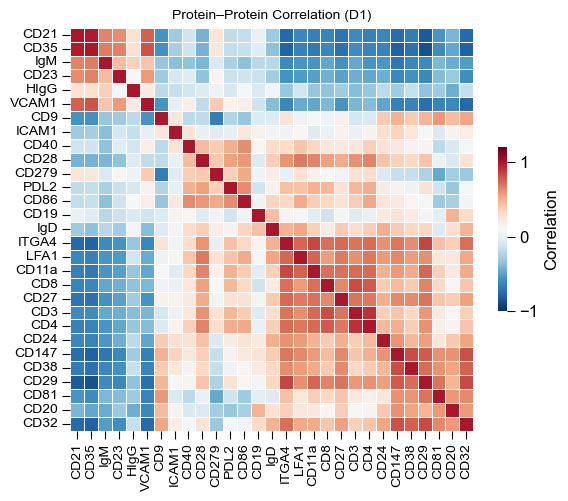

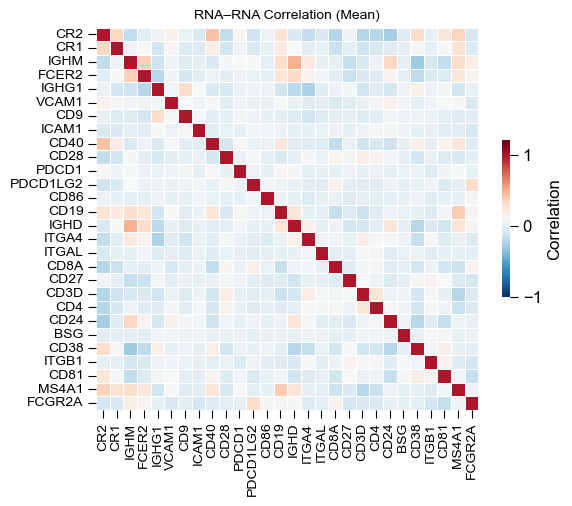

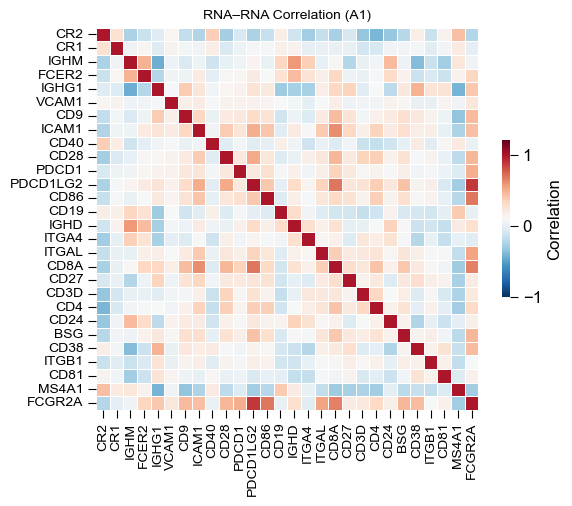

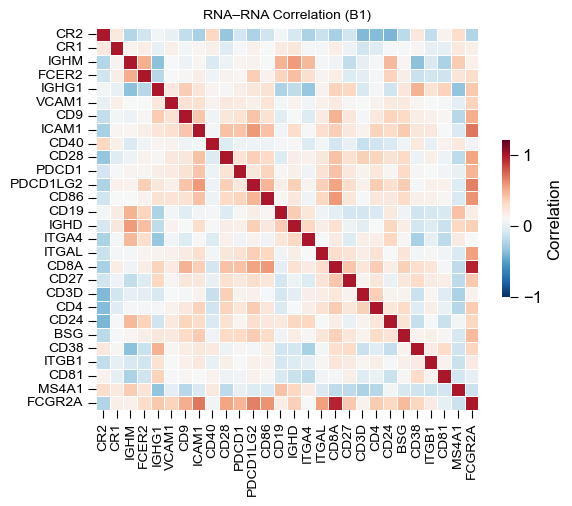

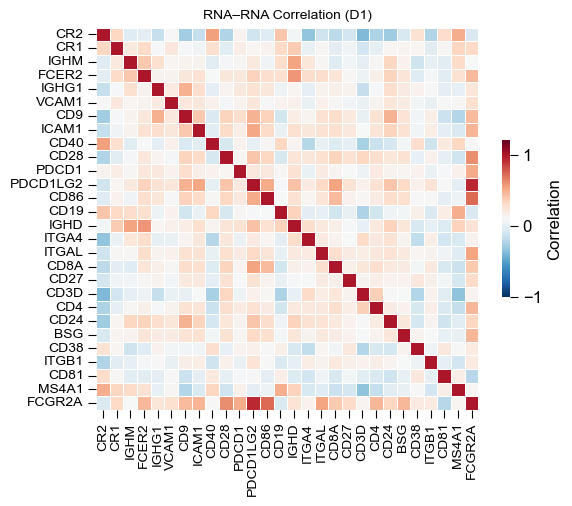

In [23]:
plot_fixed_order_correlation_heatmaps(corr_dict_protein, corr_dict_rna, protein_to_gene,  save=True,
    output_dir="my_output_folder/Fig-2bc")

In [24]:
rna_dict = {"A1": rna_A1, "B1": rna_B1, "D1": rna_D1}
protein_dict = {"A1": protein_A1, "B1": protein_B1, "D1": protein_D1}
pla_pair_dict = {"A1": protein_pair_A1,"B1": protein_pair_B1, "D1": protein_pair_D1,}

In [25]:
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import os

def compare_means(df1, df2, log=True):
    """
    Compare mean expression across features between two samples.
    Only keeps shared features.
    """
    mean1 = df1.mean(axis=0)
    mean2 = df2.mean(axis=0)
    common = mean1.index.intersection(mean2.index)
    df = pd.DataFrame({
        "sample1": mean1[common],
        "sample2": mean2[common]
    })
    if log:
        df = df[(df > 0).all(axis=1)]  # Skip features with 0 in either sample
    return df

def plot_sample_pair(df, ax, label1, label2, title):
    """
    Plot one comparison panel with regression line and correlation.
    """
    corr = stats.pearsonr(df["sample1"], df["sample2"])[0]
    n = df.shape[0]
    sns.scatterplot(data=df, x="sample1", y="sample2", s=20, ax=ax)
    sns.regplot(data=df, x="sample1", y="sample2", scatter=False, ax=ax,
                line_kws={"color": "skyblue", "lw": 2})
    ax.set_title(f"{title}\nCorrelation = {corr:.3f} (n = {n})")
    ax.set_xlabel(f"Sample {label1}")
    ax.set_ylabel(f"Sample {label2}")
    ax.set_aspect('equal', adjustable='box')

def plot_all_pairwise_correlations(rna_dict, protein_dict, pla_pair_dict,
                                   save_path="figures/Extended-Fig-3.svg"):
    """
    Plot and optionally save pairwise scatter plots of RNA, protein, and PLA pair correlations.

    Parameters:
        rna_dict: dict of sample_name -> RNA DataFrame
        protein_dict: dict of sample_name -> Protein DataFrame
        pla_pair_dict: dict of sample_name -> PLA pair DataFrame
        save_path: file path to save the figure
    """
    sample_pairs = list(combinations(rna_dict.keys(), 2))
    num_pairs = len(sample_pairs)
    fig, axes = plt.subplots(3, num_pairs, figsize=(3 * num_pairs, 9), squeeze=False)

    for i, (s1, s2) in enumerate(sample_pairs):
        
        # RNA comparison
        rna_df = compare_means(rna_dict[s1], rna_dict[s2])
        plot_sample_pair(rna_df, axes[1, i], s1, s2, "Normalized mRNA expression")

        # Protein comparison
        prot_df = compare_means(protein_dict[s1], protein_dict[s2])
        plot_sample_pair(prot_df, axes[0, i], s1, s2, "Normalized protein expression")

        # PLA pair comparison
        pla_df = compare_means(pla_pair_dict[s1], pla_pair_dict[s2])
        plot_sample_pair(pla_df, axes[2, i], s1, s2, "Normalized PLA counts")

    plt.tight_layout()
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    print(f"✅ Plot saved to {save_path}")
    plt.show()


✅ Plot saved to figures/Extended-Fig-3.svg


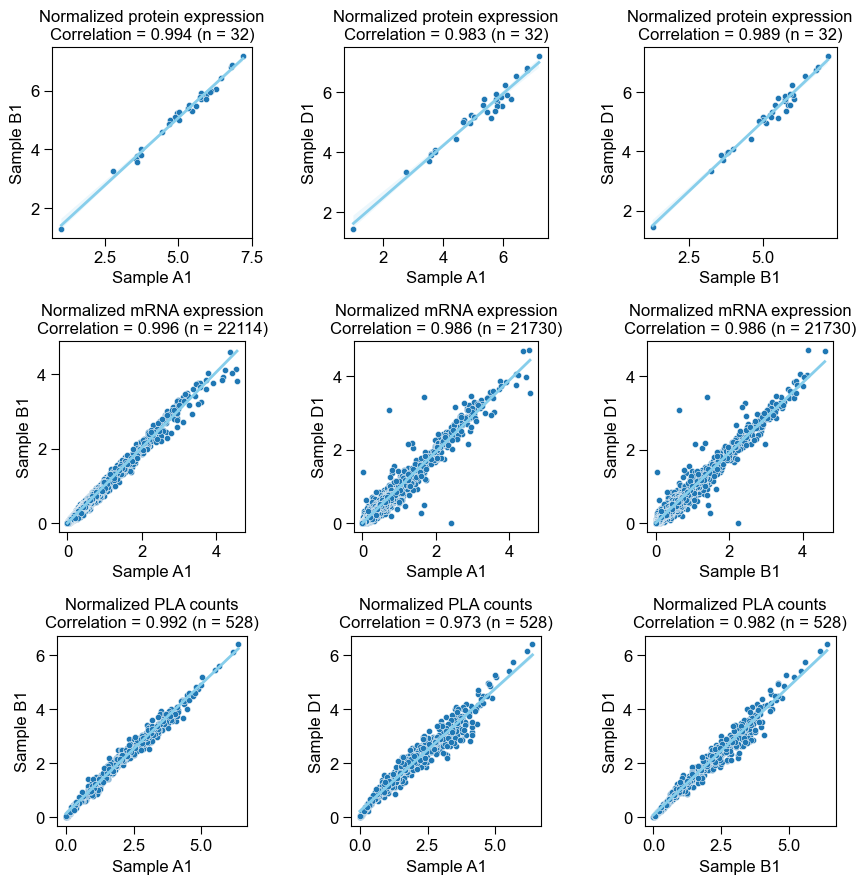

In [26]:
plot_all_pairwise_correlations(rna_dict, protein_dict, pla_pair_dict)
